# Лабораторная работа №2: Анализ речевых сигналов при помощи дискретного преобразования Фурье

Выполнил студент группы 9381 Колованов Родион Алексеевич, Вариант 7.

## Цель работы

Практическое применение дискретного преобразования Фурье c использованием библиотек Python для анализа речевых сигналов.

## Задачи работы

1. Используя ДПФ построить траекторию основного тона (F0) на записи своего голоса;
2. Используя ДПФ построить траектории второй, третьей и четвертой формантных частот на записи своего голоса;
3. Построить сонограмму по записи своего голоса.

## Выполнение работы

### Загрузка аудиофайла

Для получения сигнала аудио-файла была использована библиотека wave. Для отрисовки графиков была использована библиотека matplotlib. Для воспроизведения измененного аудио-сигнала была использована библиотека IPython.

Для начала подключим нужные библиотеки:

In [68]:
import numpy as np
import scipy.signal as spectrogram
import IPython.display as ipd
import matplotlib.pyplot as plt
import more_itertools as mit
import wave

%matplotlib inline

Далее загрузим аудио-файл ***'data/voice.wav'*** и получим его аудио-сигнал:

In [69]:
filename = "data/voice.wav"

types = {
    1: np.int8,
    2: np.int16,
    4: np.int32
}

audiofile = wave.open(filename, "rb")
signal = np.frombuffer(audiofile.readframes(audiofile.getnframes()), types[audiofile.getsampwidth()])
framerate = audiofile.getframerate()

Отобразим основную информацию об аудио-файле:

In [70]:
print("Channels:", audiofile.getnchannels())
print("Sample width:", audiofile.getsampwidth())
print("Frame rate:", audiofile.getframerate())
print("Frames:", audiofile.getnframes())
print("Compression type:", audiofile.getcomptype())
print("Compression name:", audiofile.getcompname())

Channels: 1
Sample width: 2
Frame rate: 16000
Frames: 90959
Compression type: NONE
Compression name: not compressed


Загруженный аудио-сигнал:

In [71]:
ipd.Audio(signal, rate=audiofile.getframerate())

Отобразим график аудио-сигнала:

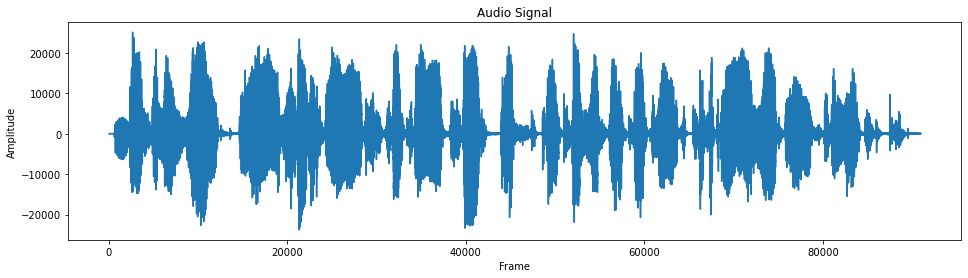

In [72]:
plt.figure(figsize=(16, 4))
plt.title("Audio Signal")
plt.ylabel("Amplitude")
plt.xlabel("Frame")
plt.plot(signal)

### Построение траектории основного тона (F0)

Функция для дискретного преобразования Фурье в матричной форме:

In [73]:
def dft(x):
    x_length = len(x)
    x = np.array(x, dtype=float)
    i = np.arange(x_length).reshape((x_length, 1))
    j = i.reshape((1, x_length))
    transformation_matrix = np.exp(2 * np.pi * 1j * i.dot(j) / x_length)
    return np.dot(transformation_matrix, x)

Начальные данные:

In [74]:
dimension = 1024
window_offset = 256
spectral_resolution = audiofile.getframerate() // dimension

print("Dimension:", dimension)
print("Window offset:", window_offset)
print("Spectral resolution:", spectral_resolution)

Dimension: 1024
Window offset: 256
Spectral resolution: 15


Построим амплитудный спектр:

In [75]:
signal_intervals = mit.windowed(signal, fillvalue=0, n=dimension, step=window_offset)
signal_intervals = list(map(lambda interval: dft(interval * np.hamming(len(interval))), signal_intervals))

amplitude_spectral = [(np.sum([i ** 2 for i in interval[:dimension//2]]) ** 0.5).real for interval in signal_intervals]

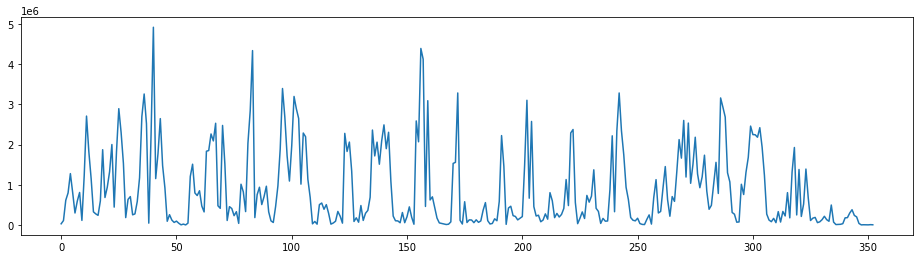

In [76]:
plt.figure(figsize=(16, 4))
plt.plot(amplitude_spectral)

Найдем траекторию основного тона F0:

In [77]:
trajectory_F0 = []

for chunk in mit.chunked(amplitude_spectral, int(spectral_resolution)):
    segment = np.array(chunk)
    if segment.max() > 2.5 * segment.mean():            
        trajectory_F0.extend(segment.tolist())
    else:
        trajectory_F0.extend([0 for i in range(len(segment))])
        

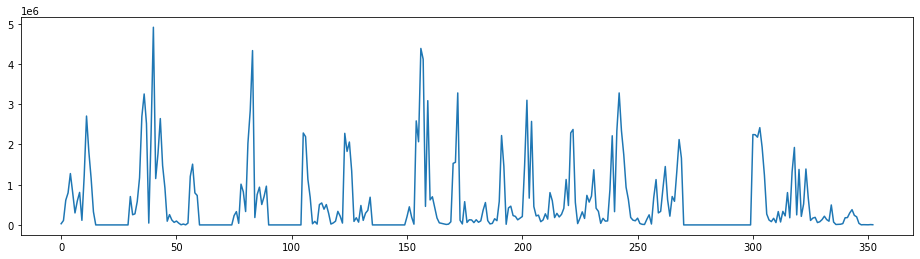

In [78]:
plt.figure(figsize=(16, 4))
plt.plot(trajectory_F0)

### Построение траектории второй, третьей и четвертой формантных частот

Найдем траекторию второй формантной частоты F1:

In [79]:
trajectory_F1 = []

i = 0
while i < len(trajectory_F0):
    try:
        max_value = max([trajectory_F0[2*i-1], trajectory_F0[2*i], trajectory_F0[2*i+1]])
        if trajectory_F0[i] > 2 * max_value:           
            trajectory_F1.append(max_value)
        else:
            trajectory_F1.append(0)
    except:
        trajectory_F1.append(0)
    i += 1


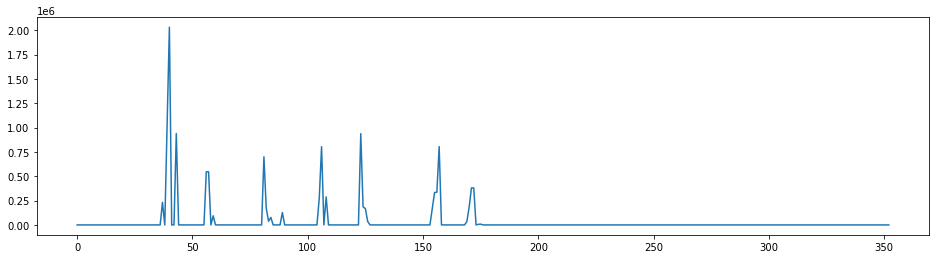

In [80]:
plt.figure(figsize=(16, 4))
plt.plot(trajectory_F1)

Найдем траекторию третьей формантной частоты F2:

In [81]:
trajectory_F2 = []

i = 0
while i < len(trajectory_F0):
    try:
        max_value = max([trajectory_F0[3*i-1], trajectory_F0[3*i], trajectory_F0[3*i+1]])
        if trajectory_F0[i] > 4 * max_value:           
            trajectory_F2.append(max_value)
        else:
            trajectory_F2.append(0)
    except:
        trajectory_F2.append(0)
    i += 1


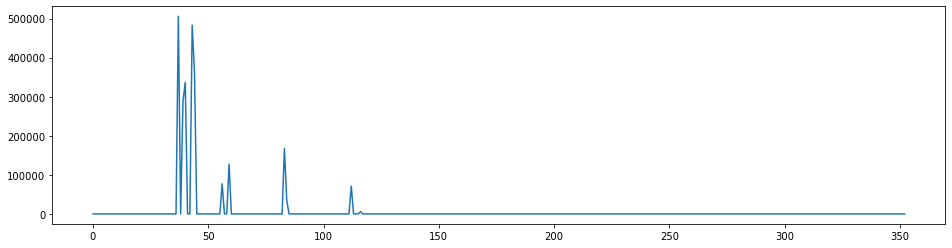

In [82]:
plt.figure(figsize=(16, 4))
plt.plot(trajectory_F2)

Найдем траекторию четвертой формантной частоты F3:

In [83]:
trajectory_F3 = []

i = 0
while i < len(trajectory_F0):
    try:
        max_value = max([trajectory_F0[4*i-1], trajectory_F0[4*i], trajectory_F0[4*i+1]])
        if trajectory_F0[i] > 8 * max_value:           
            trajectory_F3.append(max_value)
        else:
            trajectory_F3.append(0)
    except:
        trajectory_F3.append(0)
    i += 1


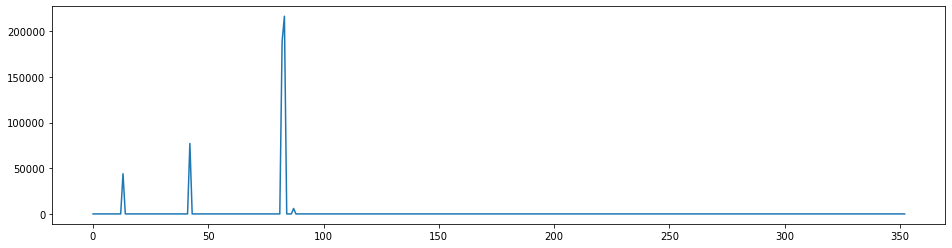

In [84]:
plt.figure(figsize=(16, 4))
plt.plot(trajectory_F3)

### Построение сонограммы сигнала

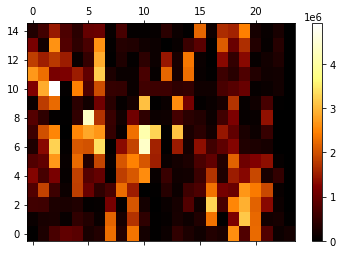

In [85]:
matrix_amp = []

for row in list(mit.chunked(amplitude_spectral, int(spectral_resolution))):
    if len(row) < int(spectral_resolution):
        row.extend([0 for _ in range(int(spectral_resolution) - len(row))])
    matrix_amp.append(row)

matrix_amp = np.array(matrix_amp)

fig, ax = plt.subplots(nrows = 1, ncols = 1)
spectogram = ax.matshow(
    np.transpose(matrix_amp,
    interpolation = "nearest",
    aspect = "auto",
    cmap = plt.cm.afmhot,
    origin = "lower",
)
fig.colorbar(spectogram)
plt.show()

## Выводы

Были изучено и применено дискретное преобразование Фурье c использованием библиотек Python с целью анализа речевых сигналов. В ходе лабораторной работы были получены навыки:

* Использования дискретного преобразования Фурье;
* Построения амплитудного спектра;
* Построения траекторий основного тона F0, а также траекторий второй, третьей и четвертой формантных частот F1, F2 и F3;
* Построения сонограммы сигнала. 